(array([False,  True]), array([1046343,    2233]))


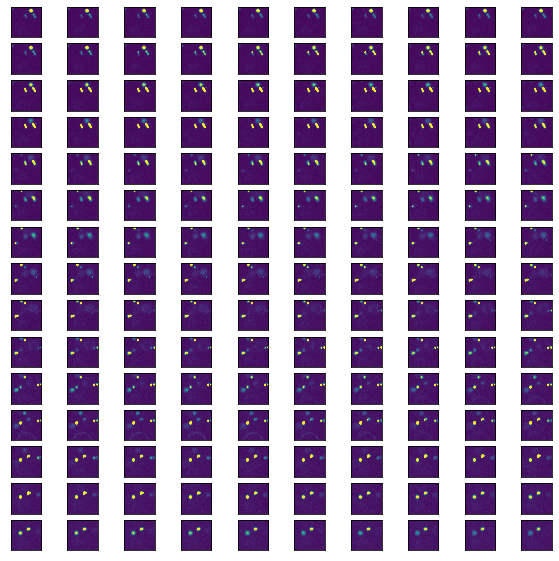

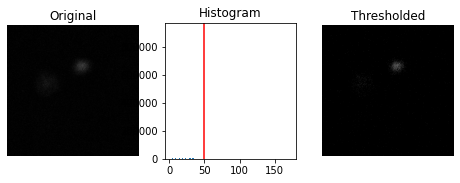

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import readlif
from readlif.reader import LifFile
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)
import matplotlib.image as matimg
import napari

import plotly
import plotly.express as px
from skimage.filters import threshold_otsu, threshold_yen
import matplotlib.animation as animation
from skimage.filters import try_all_threshold
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

def plot_hist(ax, data, title=None):
    # Helper function for plotting histograms
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    if title:
        ax.set_title(title)

def show_plane(ax, plane, title=None):
    # ax.imshow(plane, vmin=2, vmax=20)
    ax.imshow(plane)
    ax.axis("off")

    if title:
        ax.set_title(title)

def display(im3d, nrow, ncol, step=1):
    _, axes = plt.subplots(nrows=nrow, ncols=ncol,figsize=(10,10))

    # vmin = im3d.min()
    # vmax = im3d.max()

    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image,  vmin=2, vmax=20)
        ax.set_xticks([])
        ax.set_yticks([])

def displaygray(im3d, nrow, ncol, step=1):
    _, axes = plt.subplots(nrows=nrow, ncols=ncol,figsize=(10,10))

    # vmin = im3d.min()
    # vmax = im3d.max()

    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image,  cmap=plt.cm.gray)
        ax.set_xticks([])
        ax.set_yticks([])

if __name__ == "__main__":
    new = LifFile('Project.lif')
    img_list = [i for i in new.get_iter_image()]

    output_array1 = np.zeros((150,1024,1024))
    for i in range(150):
        # ------------------------------------------------------------------------------------
        framei = img_list[0].get_frame(z=i, t=0.7, c=0)
        img = np.array(framei)
        output_array1[i] = img
    img1 = np.dstack(output_array1)

    display(output_array1, 15, 10)

    image = output_array1[40]
    image = exposure.adjust_log(img, 1)
    thresh = threshold_yen(image)
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded')
    ax[2].axis('off')

    # print(binary[0:20][0:20])
    counts=np.unique(binary,return_counts=True)
    print(counts)
    plt.show()




In [18]:
    original_spacing = np.array([0.2900000, 0.0650000, 0.0650000])

    # We downsampled each slice 4x to make the data smaller
    rescaled_spacing = original_spacing * [1, 4, 4]

    # Normalize the spacing so that pixels are a distance of 1 apart
    spacing = rescaled_spacing / rescaled_spacing[2]

    viewer = napari.view_image(output_array1, 
                               scale=spacing)
    
    # napari.run()
    

In [3]:
thresed = output_array1
for i in range(150):
    thresed[i] = output_array1[i] > threshold_yen(output_array1[i])
viewer.add_image(thresed, name='thresholded', opacity=0.3)

<Image layer 'thresholded' at 0x7f90c1a326a0>

In [16]:
noise = thresed[115]

In [19]:
for i in range(150):
    output_array1[i]=exposure.adjust_gamma(output_array1[i], 1.4)

In [20]:
thresed = output_array1
thresval = (threshold_yen(output_array1[81])+threshold_yen(output_array1[61])+threshold_yen(output_array1[71]))/3
for i in range(150):
    thresed[i] = output_array1[i] > thresval
viewer.add_image(thresed, name='thresholded', opacity=0.3)

<Image layer 'thresholded' at 0x7f8df4a2de50>

In [21]:
nonnoise = thresed[115]

In [6]:
# from skimage.filters import try_all_threshold

# fig, ax = try_all_threshold(output_array1[30], figsize=(10, 8), verbose=False)
# plt.show()

In [7]:
thresed = thresed.astype(int)
labels = measure.label(thresed)
remove_objects = morphology.remove_small_objects(
    labels, 
    min_size= 20
)

viewer.add_labels(labels, name='labels')
viewer.add_image(remove_objects, name='cleaned')

<Image layer 'cleaned' at 0x7f90c1bd35b0>

In [8]:
props = measure.regionprops_table(labels,
...                           properties=['label', 'area'
...                                      ])
import pandas as pd  
df = pd.DataFrame(props)  

filt = df.loc[df.area.gt(8000), 'label']
mask = np.isin(labels, filt).astype(int)
filtlabels = measure.label(mask)
viewer.add_labels(filtlabels, name='filtlabels')

<Labels layer 'filtlabels' at 0x7f90c10346a0>

In [9]:
propsnew = measure.regionprops_table(filtlabels,
...                           properties=['label', 'area'
...                                      ])
print(propsnew)

{'label': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 'area': array([ 61310, 183477,  77142,  82581, 119943,  44765,  87944, 172822,
        31804, 143711,   9150])}


In [10]:
# dilate = morphology.binary_dilation(mask[50])

# erode = morphology.binary_erosion(mask[50])

# fig, axes = plt.subplots(ncols=3, figsize=(30, 8))
# ax = axes.ravel()
# ax[0] = plt.subplot(1, 3, 1)
# ax[1] = plt.subplot(1, 3, 2)
# ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

# ax[0].imshow(dilate, cmap=plt.cm.gray)
# ax[0].set_title('Dilation')
# ax[0].axis('off')

# ax[1].imshow(mask[50], cmap=plt.cm.gray)
# ax[1].set_title('Original')
# ax[1].axis('off')

# ax[2].imshow(erode, cmap=plt.cm.gray)
# ax[2].set_title('Erosion')
# ax[2].axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

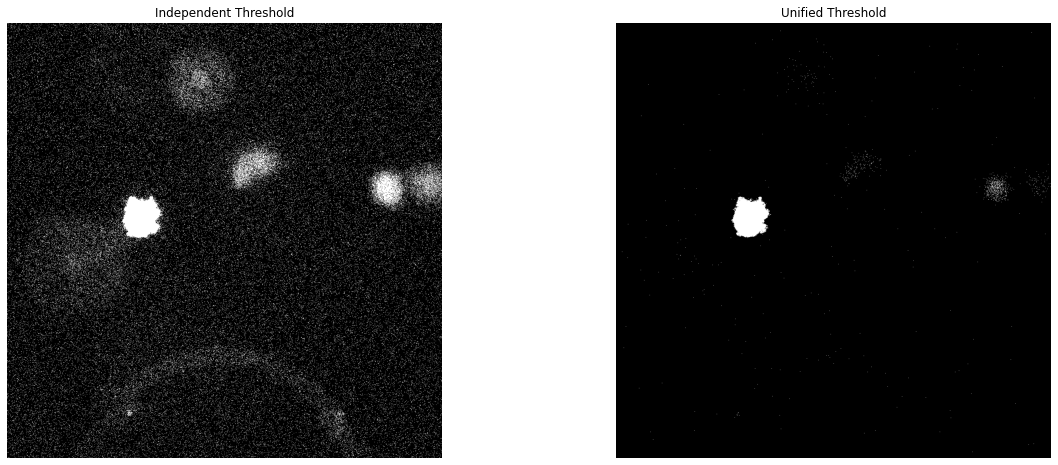

In [24]:


fig, axes = plt.subplots(ncols=2, figsize=(20, 8))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[1] = plt.subplot(1, 2, 2, sharex=ax[0], sharey=ax[0])

ax[0].imshow(noise, cmap=plt.cm.gray)
ax[0].set_title('Independent Threshold')
ax[0].axis('off')

ax[1].imshow(nonnoise, cmap=plt.cm.gray)
ax[1].set_title('Unified Threshold')
ax[1].axis('off')


In [12]:
A = (output_array1[100])*256
from PIL import Image
im = Image.fromarray(A)
im = im.convert("RGB")
im.save("filename.jpeg")

In [13]:
np.amax(A)

256.0

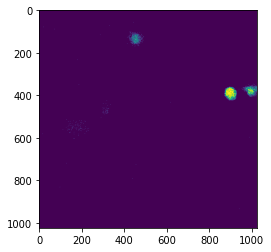

In [14]:
plt.imshow(output_array1[100])


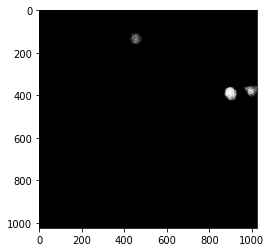

In [15]:
plt.imshow(mask[100],cmap=plt.cm.gray)
